In [1]:
from os import path as osp
import numpy as np
import tensorflow as tf
import sonnet as snt

import matplotlib.pyplot as plt
% matplotlib inline

from neurocity.tools.params import num_trainable_params

from tf_tools.eval import make_expr_logger

from data import load_data, tensors_from_data
from model import AIRCell

In [2]:
learning_rate = 1e-4
batch_size = 64
img_size = 50, 50
crop_size = 20, 20
n_latent = 50
n_hidden = 256
n_steps = 3

logdir = 'supervised'
checkpoint_name = osp.join(logdir, 'model.ckpt')
axes = {'imgs': 0, 'labels': 0, 'nums': 1}

In [3]:
test_data = load_data('data/mnist_test.pickle')
train_data = load_data('data/mnist_train.pickle')

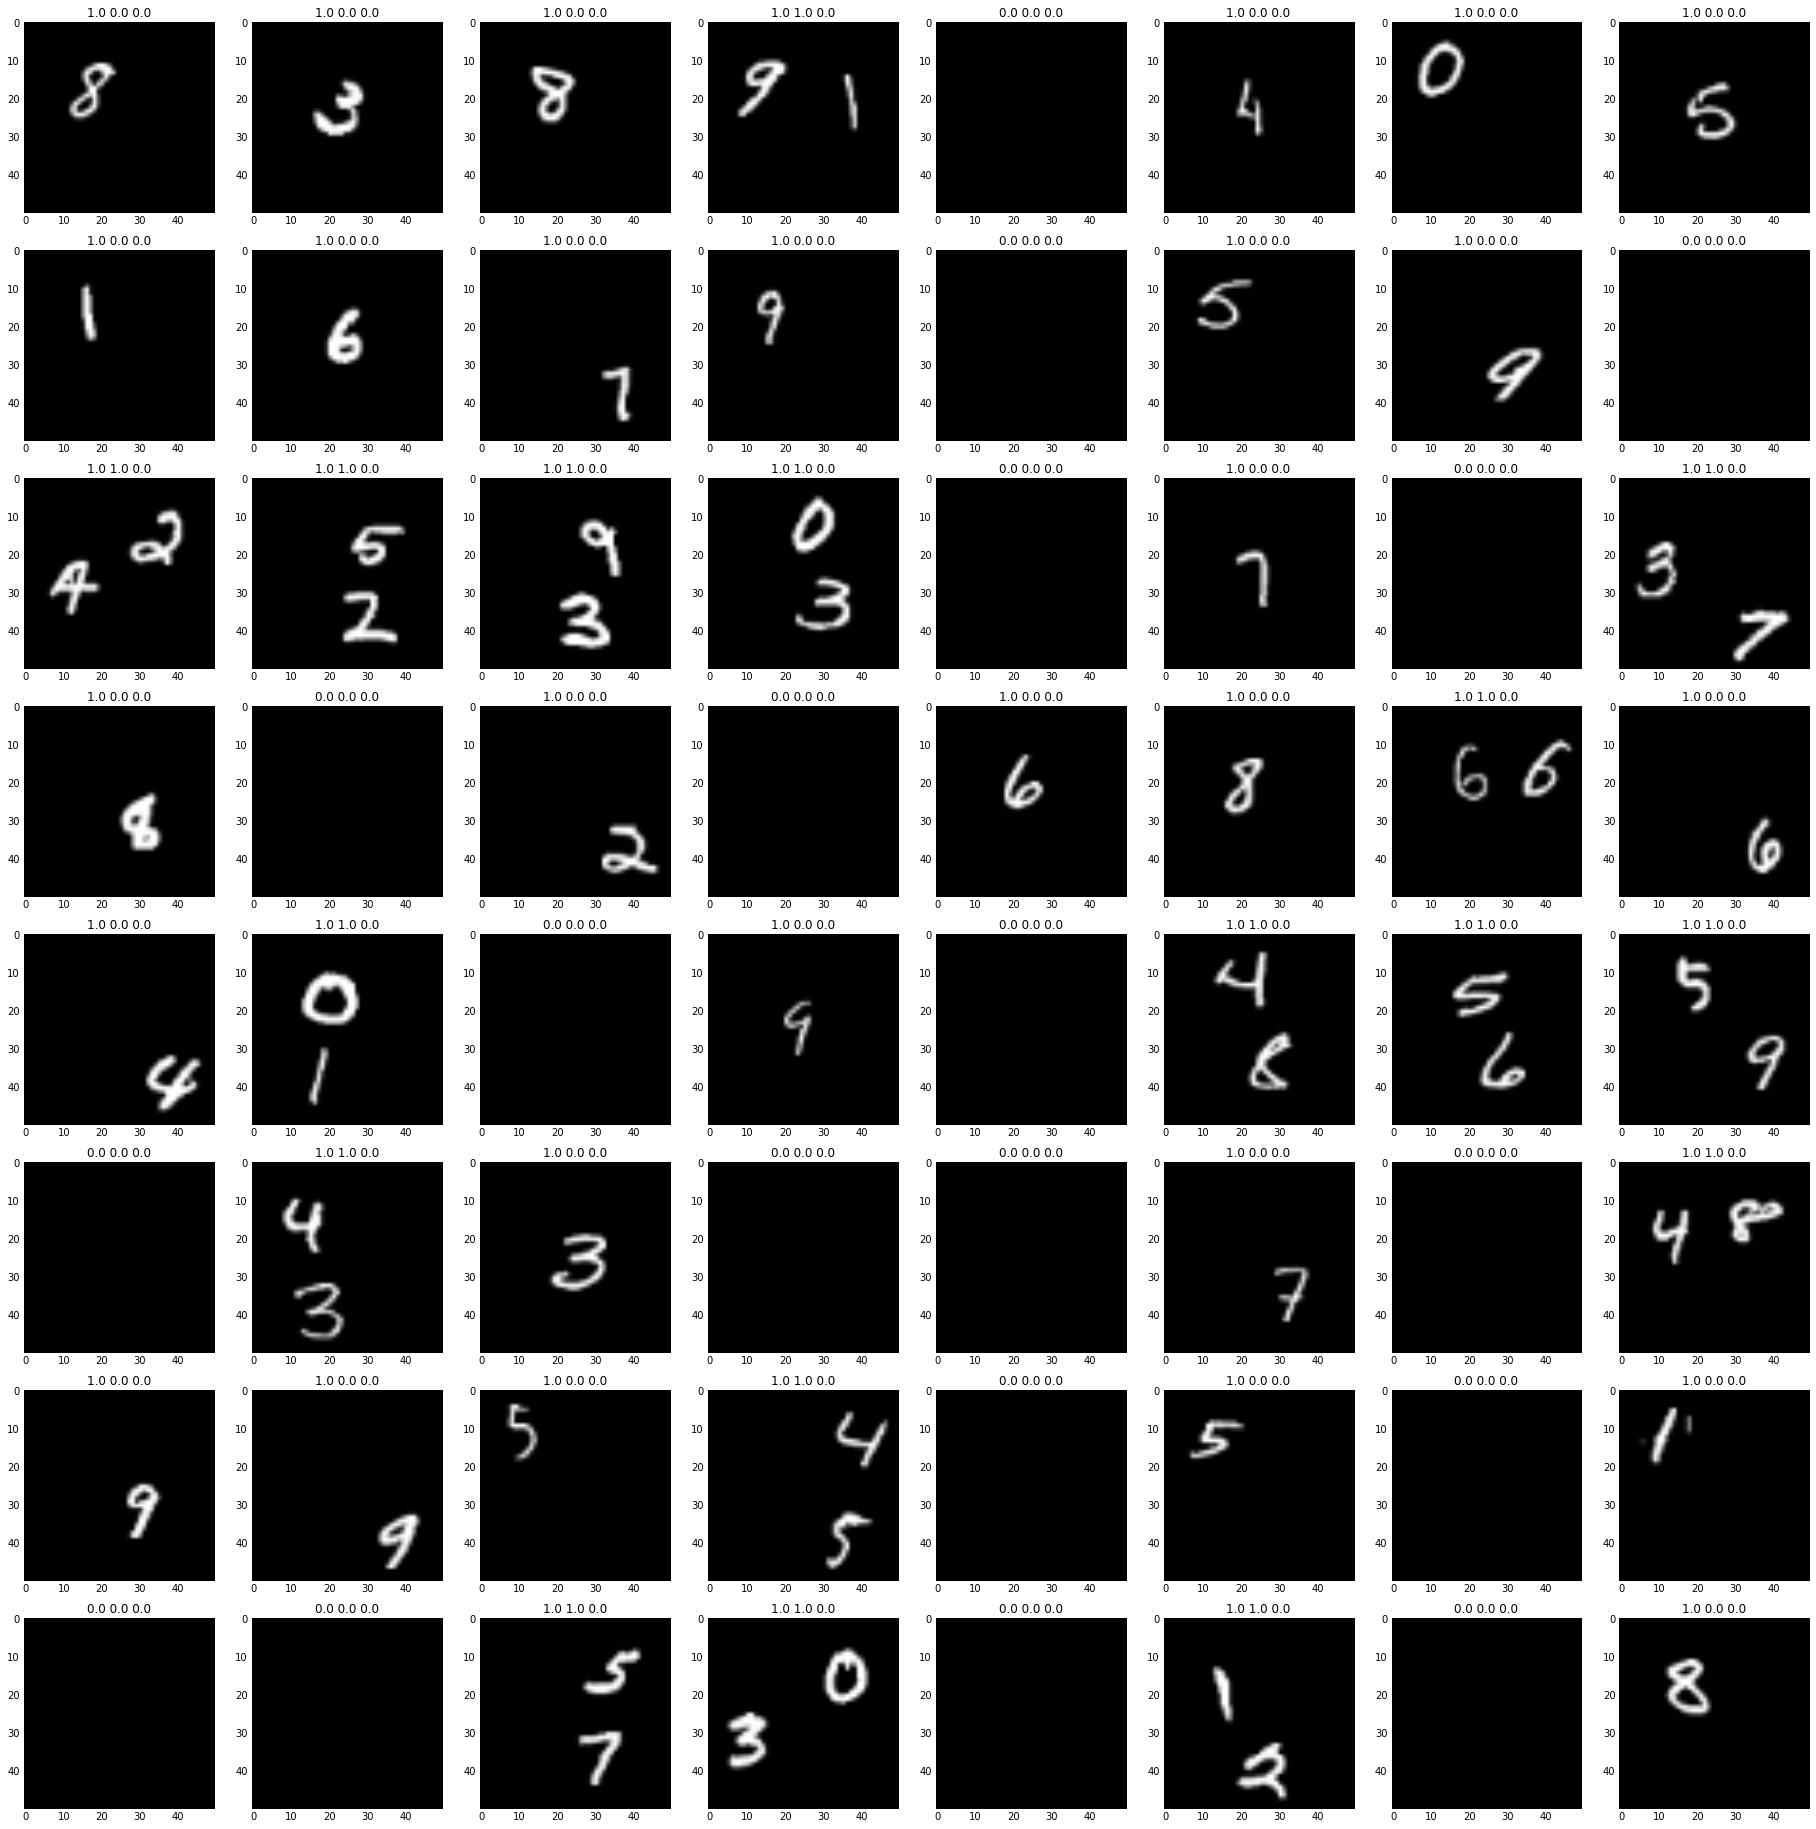

In [4]:
imgs = train_data['imgs']
nums = train_data['nums']

fig, fig_axes = plt.subplots(8, 8, figsize=(32, 32))
idx = np.random.choice(imgs.shape[0], 64)
for i, ax in zip(idx, fig_axes.flatten()):
    ax.imshow(imgs[i], cmap='gray')
    num_str = ' '.join([str(n) for n in nums[:, i].squeeze()])
    ax.set_title(num_str)

In [5]:
tf.reset_default_graph()
train_tensors = tensors_from_data(train_data, batch_size, axes, shuffle=True)
test_tensors = tensors_from_data(test_data, batch_size, axes, shuffle=False)
x, test_x = train_tensors['imgs'], test_tensors['imgs']
y, test_y = train_tensors['nums'], test_tensors['nums']

transition = snt.LSTM(n_hidden)
air = AIRCell(img_size, crop_size, n_latent, transition)
initial_state = air.initial_state(x)

dummy_sequence = tf.zeros((n_steps, batch_size, 1), name='dummy_sequence')
outputs, state = tf.nn.dynamic_rnn(air, dummy_sequence, initial_state=initial_state, time_major=True)
canvas, cropped, what, where, presence_logit = outputs
presence = tf.nn.sigmoid(presence_logit)

cropped = tf.reshape(presence * tf.nn.sigmoid(cropped), (n_steps, batch_size,) + tuple(crop_size))
canvas = tf.reshape(canvas, (n_steps, batch_size,) + tuple(img_size))
prob_canvas = tf.nn.sigmoid(canvas)
final_canvas = canvas[-1]

[tf.float32, tf.uint8, tf.float32]
[tf.float32, tf.uint8, tf.float32]


In [6]:
print num_trainable_params()

992981


In [7]:
# loss = ((x - final_canvas)**2
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=final_canvas)

rec_loss = tf.reduce_mean(tf.reduce_sum(loss, axis=(1, 2)))
tf.summary.scalar('rec_loss', rec_loss)

alpha= 10.
num_steps_penalty = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=presence_logit)
num_steps_penalty = tf.reduce_mean(num_steps_penalty)
tf.summary.scalar('steps_loss', num_steps_penalty)

loss = rec_loss + alpha * num_steps_penalty
tf.summary.scalar('loss', loss)

# opt = tf.train.AdamOptimizer(learning_rate)
opt = tf.train.RMSPropOptimizer(learning_rate, momentum=.9, centered=True)
train_step = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
all_summaries = tf.summary.merge_all()

In [9]:
summary_writer = tf.summary.FileWriter(logdir)
saver = tf.train.Saver()

In [10]:
imgs = train_data['imgs']
presence_gt = train_data['nums']
train_itr = 0

In [45]:
def make_fig(checkpoint_dir, global_step):
    xx, pred_canvas, pred_crop, pres = sess.run([x, prob_canvas, cropped, presence])

    max_imgs = 10
    bs = min(max_imgs, batch_size)
    scale = 3.
    figsize = scale * np.asarray((bs, 2 * n_steps + 1))
    fig, axes = plt.subplots(2 * n_steps + 1, bs, figsize=figsize)

    for i, ax in enumerate(axes[0]):
        ax.imshow(xx[i], cmap='gray', vmin=0, vmax=1)

    for i, ax_row in enumerate(axes[1:1+n_steps]):
        for j, ax in enumerate(ax_row):
            ax.imshow(pred_canvas[i, j], cmap='gray', vmin=0, vmax=1)

    for i, ax_row in enumerate(axes[1+n_steps:]):
        for j, ax in enumerate(ax_row):
            ax.imshow(pred_crop[i, j], cmap='gray', vmin=0, vmax=1)
            ax.set_title('{:.02f}'.format(pres[i, j, 0]))

    for ax in axes.flatten():
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    
    fig_name = osp.join(checkpoint_dir, 'progress_fig_{}.png'.format(global_step))
    fig.savefig(fig_name, dpi=300)
    plt.close('all')
    
exprs = dict(loss=loss, rec_loss=rec_loss, steps_loss=num_steps_penalty)
train_log = make_expr_logger(sess, summary_writer, train_data['imgs'].shape[0] / batch_size, exprs, name='train')
test_log = make_expr_logger(sess, summary_writer, test_data['imgs'].shape[0] / batch_size, exprs, name='test', data_dict={x: test_x, y: test_y})

def log(train_itr):
    train_log(train_itr)
    test_log(train_itr)

In [ ]:
log(train_itr)
for train_itr in xrange(train_itr+1, int(1e7)):
    
    sess.run(train_step)       
    if train_itr % 1000 == 0:
        summaries = sess.run(all_summaries)
        summary_writer.add_summary(summaries, train_itr)
        
    if train_itr % 10000 == 0:
        log(train_itr)
        
    if train_itr % 25000 == 0:
        saver.save(sess, checkpoint_name, global_step=train_itr)
        make_fig(logdir, train_itr)    

5700 [64.73291, 61.837902, 0.28950104]
5800 [71.388077, 68.60585, 0.27822268]
5900 [65.026794, 62.383072, 0.26437259]
6000 [62.274193, 59.644096, 0.26300961]
Step 6000, Data train loss = 66.5908, steps_loss = 0.2729, rec_loss = 63.8614, eval time = 22.28s
Step 6000, Data test loss = 61.3447, steps_loss = 0.2773, rec_loss = 58.5716, eval time = 0.365s
6100 [60.448673, 57.861191, 0.25874826]
6200 [70.437462, 67.666275, 0.27711865]
6300 [58.748703, 56.093819, 0.26548842]
6400 [51.20863, 48.476677, 0.27319539]
6500 [46.443699, 44.026459, 0.24172403]
6600 [60.120651, 57.561516, 0.25591338]
6700 [65.719696, 63.319275, 0.24004179]
6800 [69.160629, 66.578011, 0.25826177]
6900 [69.808296, 67.144348, 0.2663947]
7000 [72.761322, 70.291077, 0.24702477]
Step 7000, Data train loss = 65.4907, steps_loss = 0.2496, rec_loss = 62.9951, eval time = 21.17s
Step 7000, Data test loss = 60.4441, steps_loss = 0.2525, rec_loss = 57.9195, eval time = 0.3761s
7100 [65.580116, 62.973885, 0.26062304]
